## Q2 : Add control variate (first order polynomial) to implement Zero variance Markov chain Monte Carlo Method (ZV-MCMC)

Avec la méthode simple de MCMC, on a déterminé l'estimateur en approximant l'espérance de $f(x)$, fonction de dimension 3 donnant la valeur des 3 paramètres, sous la loi \pi, i.e la loi normale (non normalisé), par la moyenne de l'échantillion simulé. On obtient alors $μ_f$. La méthode Zero variance Markov chain Monte Carlo consiste to reduce the MCMC error by replacing $f$ with a different function,  \tilde{f}, obtained by properly re-normalizing $f$. The function \tilde{f} is constructed so that its expectation, under \pi , equals $μ_f$ , but its variance with respect to \pi is much smaller.

Procédure of ZV-MCMC :

* 1ère étape : conduire une courte simulation MCMC pour estimer les paramètres de la trial function
    
* 2ème étape : conduire une longue simulation pour estimate the posterior mean of each parameter

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from scipy.optimize import minimize

In [2]:
os.chdir("/Users/ludovic/Desktop/ENSAE/S2/MC/Garch_ZV_MCMC") #set up the location of the project 

#### Simulation of data following a GARCH(1,1) process

Il faudrait write en csv les ddonnées de la q1 et repartir des mêmes.

In [3]:
N = 5000  #Run size
n = 1000  #Burn-in size
a = [0.8, 0.2, 0.5] # parameters of the GARCH model : omega, alpha, beta 

In [4]:
def garch_11(parameters, N):   #Size of the generated data
    r = np.zeros(N)  # r corresponds to the Garch process
    h = np.zeros(N)  # h corresponds to the volatility : h=sigma^2

    # We define the initial values of e and h 
    r[0] = 0.1
    h[0] = 0.01

    WN = np.random.normal(0, 1, N)  # noise follows a Normal(0,1)

    for i in range(1, N):
        h[i] = parameters[0] + parameters[1] * r[i-1]**2 + parameters[2] * h[i-1]
        r[i] = np.sqrt(h[i]) * WN[i]

    return r,h

In [5]:
r_garch = garch_11(a, N)[0][(n + 1):N]

### 1er MCMC

In [6]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial # How to fix h? Proposition : max g0 initial
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [7]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garch)

3.8360176902264924

In [8]:
M = 3000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.8, 0.2, 0.5] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.014  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Algorythm :

In [9]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = g(Y, data = r_garch, h_initial=h_initial) - g(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000
 ... 6000


#### Exploitation of the results

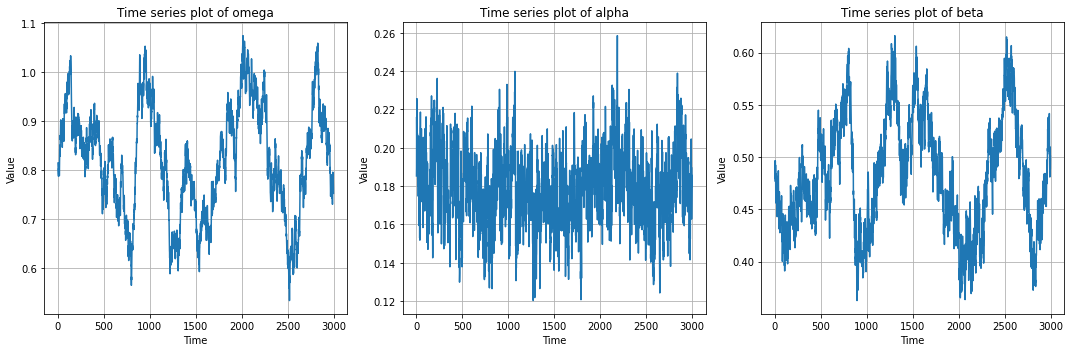

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [11]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

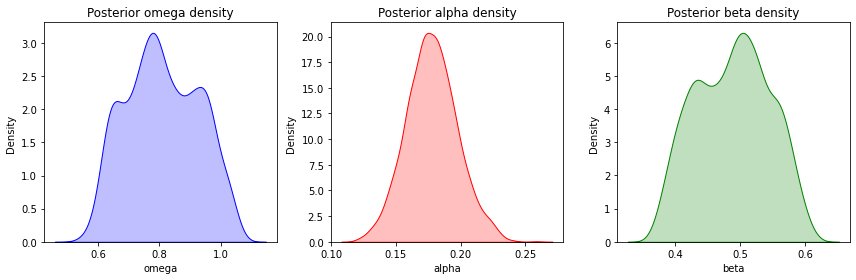

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [13]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 3000 iterations, with burn-in 600
acceptance rate = 0.4985873358816686
mean of x1 is about 0.8103138501737077
mean of x2 is about 0.17762847257451114
mean of x3 is about 0.4879173332224544


## Control variate estimation

In [14]:
X_stack = np.vstack([x1list[(B):(len(x1list))], x2list[(B):(len(x2list))], x3list[(B):(len(x3list))]])

In [15]:
X_stack = X_stack.T

In [16]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial 
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [17]:
g = list(map(lambda x: g(x, data=r_garch, h_initial=h_initial), X_stack))

In [18]:
def z1_i(r,h):
    gradient_1 = 1/2*(r / h)
    return gradient_1
def z1(x , data, h_initial):
    h = h_initial
    Z = z1_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z1_i(data[i],h)

    return Z

In [19]:
def z2_i(r,h):
    gradient_2 = 0.25 * (1/h) - 0.25 * (r**2 / h**2)
    return gradient_2
def z2(x , data, h_initial):
    h = h_initial
    Z = z2_i(data[0],h)
    
    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z2_i(data[i],h)

    return Z

In [20]:
gradient1 = list(map(lambda x: z1(x, data=r_garch, h_initial=h_initial), X_stack))

In [21]:
gradient2 = list(map(lambda x: z2(x, data=r_garch, h_initial=h_initial), X_stack))

In [22]:
X = np.vstack([gradient1]).T
X = sm.add_constant(X) # Ajout d'une constante pour ajuster l'ordonnée à l'origine
y = g
model = sm.OLS(y, X).fit(cov_type='HC3') # ajustement du modèle de régression linéaire
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     98.61
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           8.44e-23
Time:                        21:57:23   Log-Likelihood:                -3806.3
No. Observations:                2400   AIC:                             7617.
Df Residuals:                    2398   BIC:                             7628.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3685.7806      0.761  -4842.885      0.0

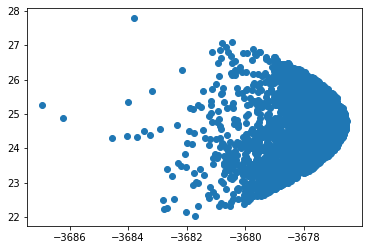

In [23]:
plt.scatter(y,gradient1)

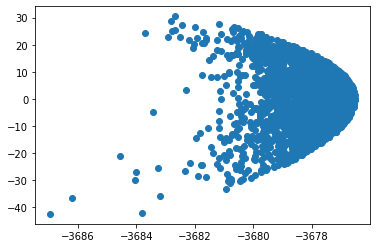

In [24]:
plt.scatter(y,gradient2)

In [25]:
def f_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) - model.params[0] - model.params[1]* 1/2 * (r / h)

def f(x , data, h_initial):
    h = h_initial 
    LL = f_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += f_i(data[i],h)

    return LL

## ZV-MCMC

est-ce qu'il faut garder le même h initial vu qu'on a changé de fonction de densité? En soi la série à estimer est la même ddonc sa volatilité aussi?

In [26]:
M = 5000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.8, 0.2, 0.5] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.012  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Algorythm :

In [27]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = f(Y, data = r_garch, h_initial=h_initial) - f(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000
 ... 6000
 ... 7000
 ... 8000
 ... 9000


#### Exploitation of the results

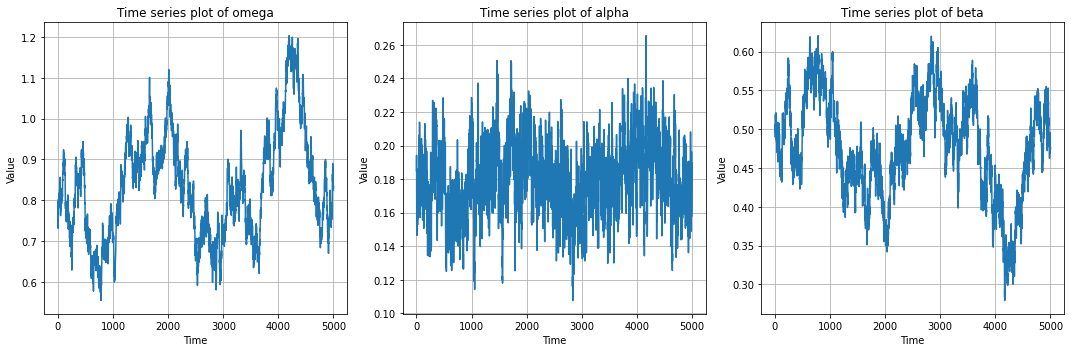

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [29]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

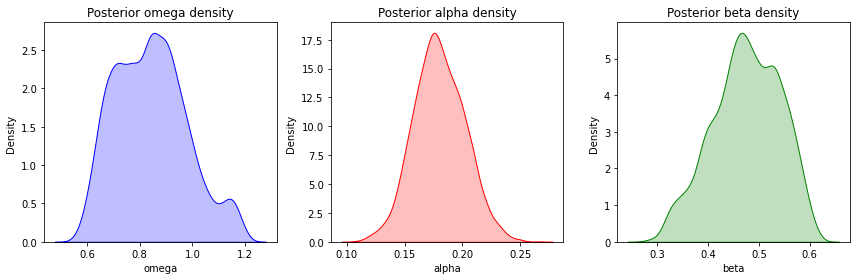

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [31]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 5000 iterations, with burn-in 600
acceptance rate = 0.5397236614853195
mean of x1 is about 0.8410483696211877
mean of x2 is about 0.1799240783217145
mean of x3 is about 0.4747728252947094


### Comparaison avec Q1

Le mieux ce serait de write en csv les 3 listes obtenus en q1 avec les données simulées (on va pas faire avec les vrais data je pense, ou vraiment à la fin), et de les réimporter ici pour faire des box plot comme dans l'article.

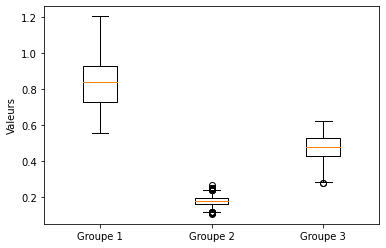

In [32]:
# Tracer le box-plot
plt.boxplot([x1list[(B):(len(x1list))], x2list[(B):(len(x2list))], x3list[(B):(len(x3list))]])

# Ajouter des étiquettes d'axe
plt.xticks(np.arange(1, 4), ['Groupe 1', 'Groupe 2', 'Groupe 3'])
plt.ylabel('Valeurs')

# Afficher le plot
plt.show()